In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan

from bmadx.beam_generator import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

In [2]:
# create synthetic ground truth beam from base and transform yaml files
data_dir = 'data'
p0c = 43.36e6 # reference momentum in eV/c
gt_beam = create_beam(base_yaml = os.path.join(data_dir,'base.yaml'),
                      transforms_yaml = os.path.join(data_dir,'transforms-nonlinear.yaml'), 
                      p0c = p0c,
                      n_particle = 10_000,
                      save_as = os.path.join('data', 'linear_beam.pt')
                      )

ground truth distribution saved at data/linear_beam.pt


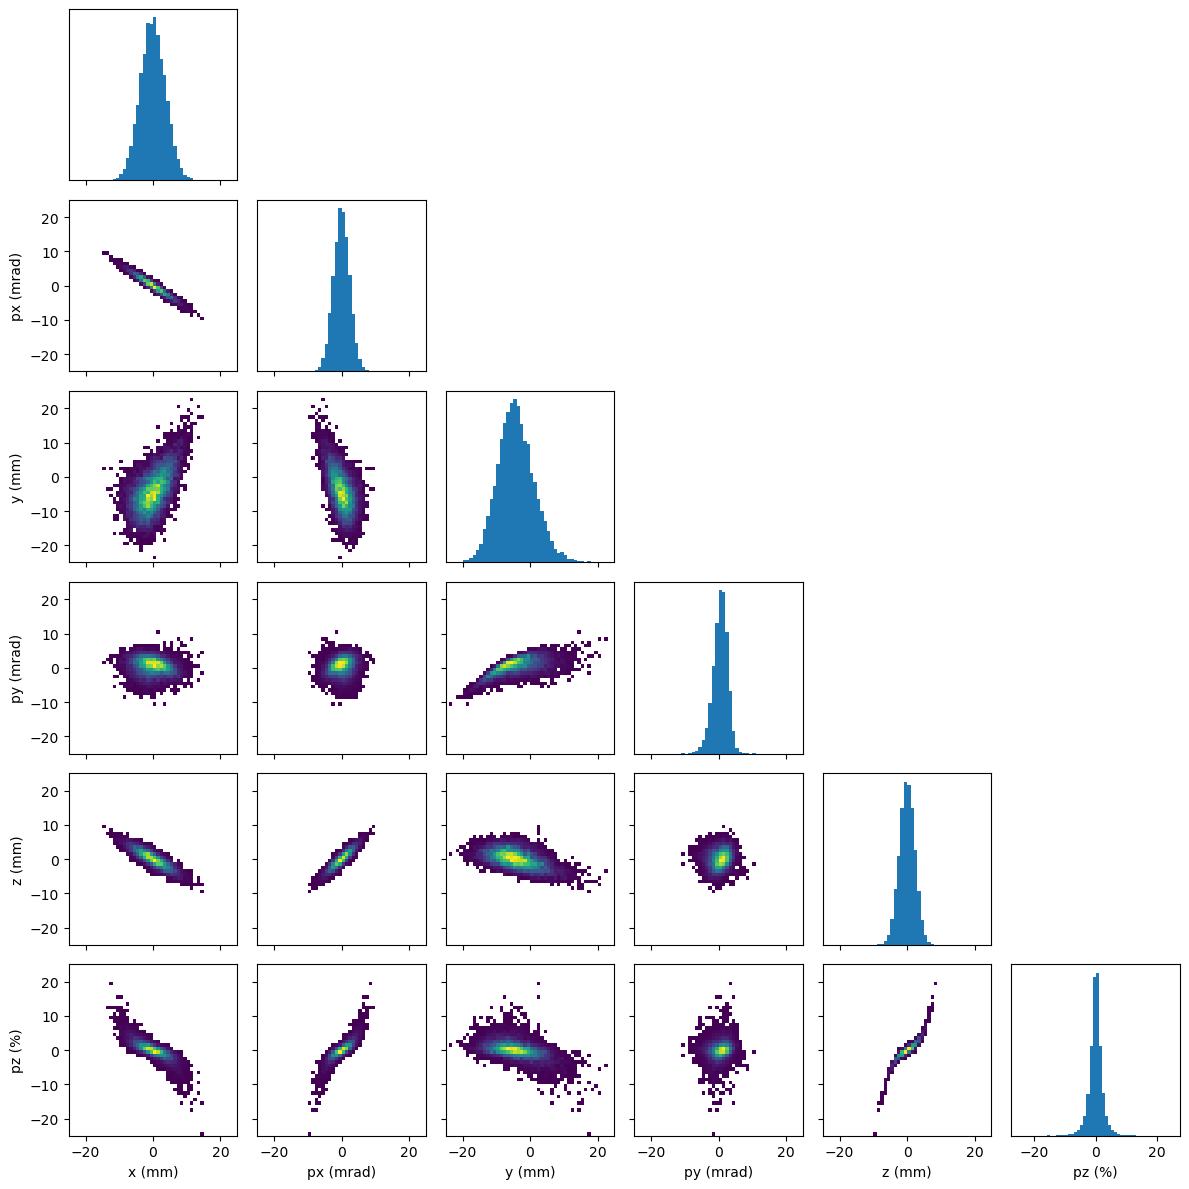

In [3]:
#plot gt beam
lims = np.array([[-25e-3, 25e-3],
                 [-25e-3, 25e-3],
                 [-25e-3, 25e-3],
                 [-25e-3, 25e-3],
                 [-25e-3, 25e-3],
                 [-25e-2, 25e-2]]) 
fig, ax = plot_projections(gt_beam.numpy_particles(), custom_lims=lims)
plt.show()

In [4]:
# obtained from triplet-opt.ipynb
k1 = 5.729234
k2 = -11.873371
k3 = 0.473122

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)


# Scan over quad strength, tdc on/off and dipole on/off
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-50, 50, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


/Users/jpga/Repositories/PS-Reconstruction/phase_space_reconstruction/phase_space_reconstruction/diagnostics.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("bandwidth", torch.tensor(bandwidth))


In [6]:
# generate and save train and test datasets
train_dset = run_t_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = [6, 8, 10],
    save_as = os.path.join('data', 'train.dset')
    )

print(train_dset.params.shape)
print(train_dset.images.shape)

torch.Size([8, 3, 1])
tensor([[-1.0000e+01,  0.0000e+00,  2.2200e-16],
        [-5.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 0.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 5.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 1.0000e+01,  0.0000e+00,  2.2200e-16],
        [ 0.0000e+00,  0.0000e+00,  9.5634e-01],
        [ 0.0000e+00,  5.0000e+06,  2.2200e-16],
        [ 0.0000e+00,  5.0000e+06,  9.5634e-01]])
dataset saved as 'data/train.dset'
torch.Size([8, 3, 1])
torch.Size([8, 1, 200, 200])


In [7]:
a = train_dset.images
a.shape

torch.Size([8, 1, 200, 200])

In [11]:
fig, ax = plot_3d_scan_data(train_dset)
plt.show()

type: shape '[5, 2, 2, 3]' is invalid for input of size 24

In [12]:
# training
pred_beam = train_3d_scan(
    train_dset, 
    lattice, 
    p0c, 
    screen,
    ids = [6 ,8, 10],
    n_epochs = 1000, 
    n_particles = 10_000, 
    device = 'cpu'
    )

Using device: cpu


/Users/jpga/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4088865., grad_fn=<MulBackward0>)
100 tensor(890046.1875, grad_fn=<MulBackward0>)
200 tensor(880258.5625, grad_fn=<MulBackward0>)
300 tensor(830264.7500, grad_fn=<MulBackward0>)
400 tensor(831413.1875, grad_fn=<MulBackward0>)
500 tensor(834929.6250, grad_fn=<MulBackward0>)
600 tensor(807775.9375, grad_fn=<MulBackward0>)
700 tensor(818190.5625, grad_fn=<MulBackward0>)
800 tensor(795043.3125, grad_fn=<MulBackward0>)
900 tensor(793870.1875, grad_fn=<MulBackward0>)


In [ ]:
# predicted screens:
pred_dset = run_3d_scan(
    pred_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = [6, 8, 10]
    )
fig, ax = plot_3d_scan_data(pred_dset)
plt.show()              

In [ ]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           custom_lims = lims
                           )
plt.show()

In [ ]:
# ground truth beam projections:
fig, ax = plot_projections(gt_beam.numpy_particles(),
                           custom_lims = lims)
plt.show()

In [ ]:
torch.cuda.empty_cache()